# Detect Noisy channels

In [1]:
import sys
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
subject = 615
# Add the workspace root to the Python path
workspace_root = os.path.abspath("../..")
if workspace_root not in sys.path:
    sys.path.append(workspace_root)
from functions import preprocess

# Load the bridged channels data
with open(os.path.join(workspace_root, 'Data', 'bridged_channels_analysis.pkl'), "rb") as f:
    all_bridged_channels = pickle.load(f)
    bridged_channels= all_bridged_channels[5][subject] # either 5 or 16 ; 16 is a stricter threshold

print('Bridged channels:', bridged_channels['bridged_ch_names'])
mne.set_log_level('ERROR')
sub = preprocess(subject)
raw = sub.load_data()
raw.notch_filter(50, fir_design='firwin', skip_by_annotation='edge')
raw.filter(l_freq=1, h_freq= 30)

Bridged channels: ['C6', 'C7', 'C9', 'C10', 'A13', 'A14', 'A24', 'A25']


c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)
c:\Users\gmoha\Downloads\git\preprocessing_pipline\functions.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  xyz_data = pd.read_csv(ch_location_path, delim_whitespace=True, skiprows=1, header=None)


<RawEDF | O_615_Def_ND.bdf, 129 x 452608 (884.0 s), ~445.6 MiB, data loaded>

In [2]:
events = mne.find_events(raw)
bad_trials=[]
all_events = sub.get_all_events_times(events).dropna()
Stim_RT_data = sub.segment_stimRt(raw, all_events, bad_trials)

In [3]:
from pyprep.find_noisy_channels import NoisyChannels
det = NoisyChannels(Stim_RT_data, do_detrend=False)
det.find_all_bads(ransac=False)
bad_ch = det.get_bads(as_dict=True)
bad_ch

{'bad_by_nan': [],
 'bad_by_flat': [],
 'bad_by_deviation': [],
 'bad_by_hf_noise': [],
 'bad_by_correlation': ['A17', 'D12', 'D22', 'D32'],
 'bad_by_SNR': [],
 'bad_by_dropout': [],
 'bad_by_ransac': [],
 'bad_all': ['D32', 'A17', 'D22', 'D12']}

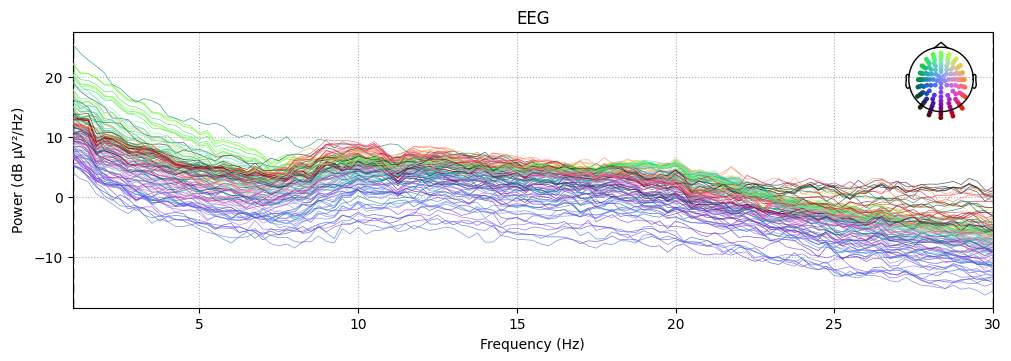

In [5]:
%matplotlib qt
Stim_RT_data.plot_psd(fmin = 1, fmax = 30)

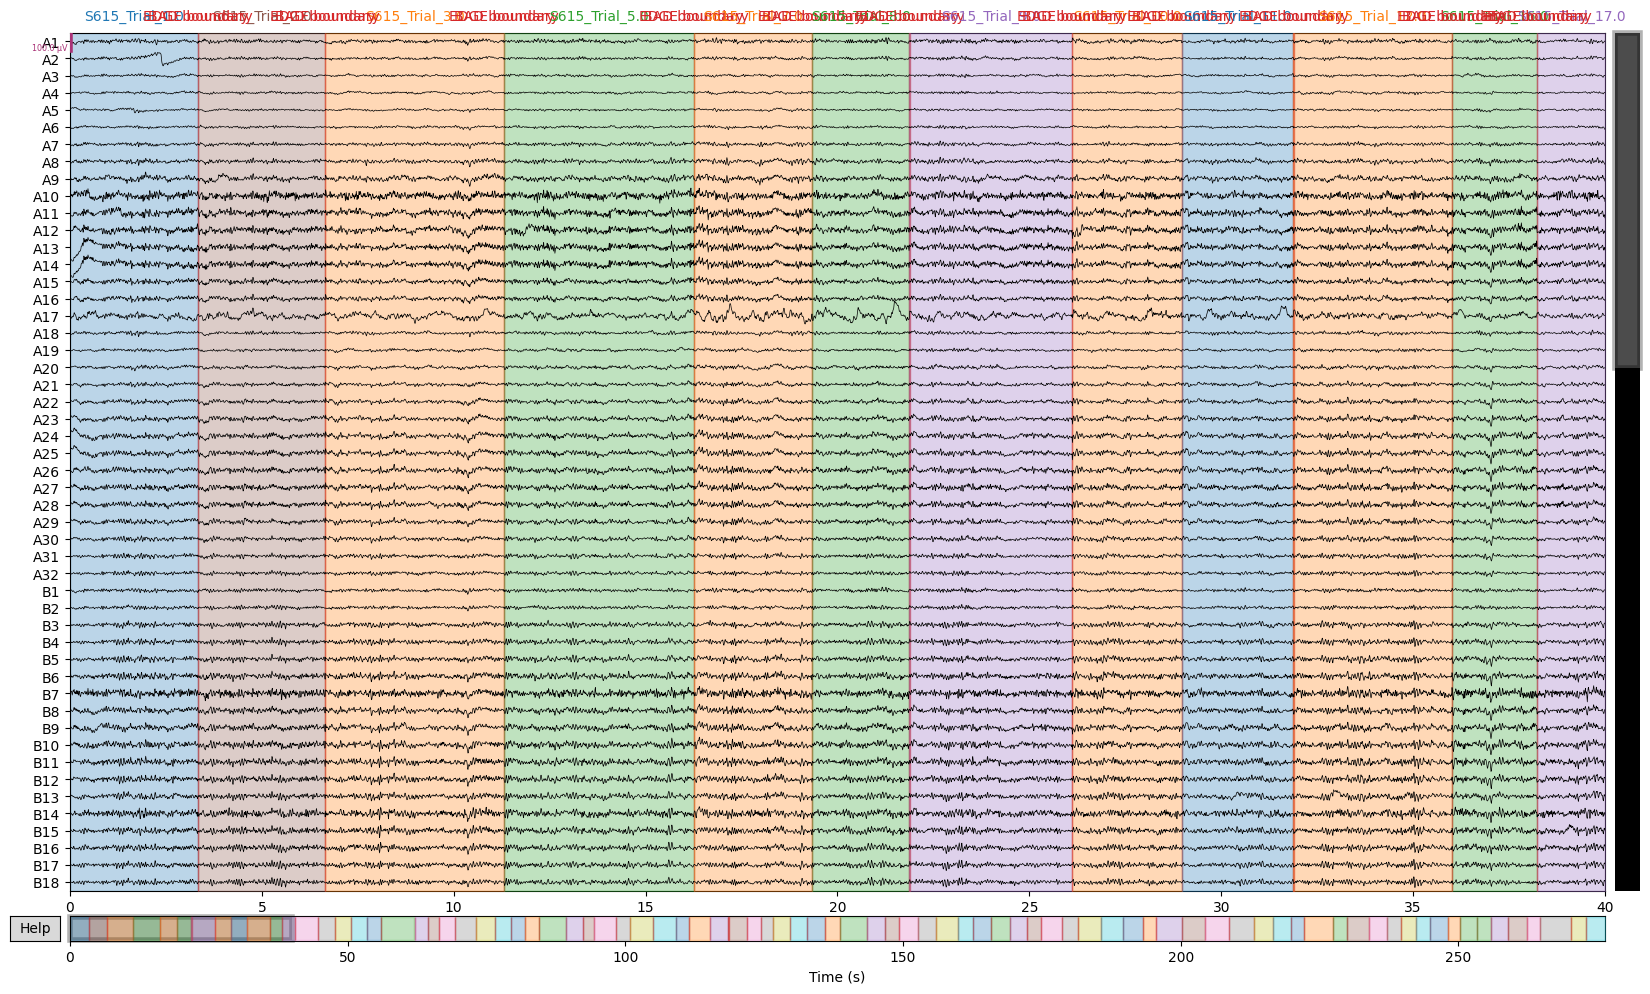

In [6]:
%matplotlib qt 
Stim_RT_data.plot( n_channels=50, scalings=dict(eeg=50e-6), picks = 'eeg', duration = 40)


# find noisy Trials

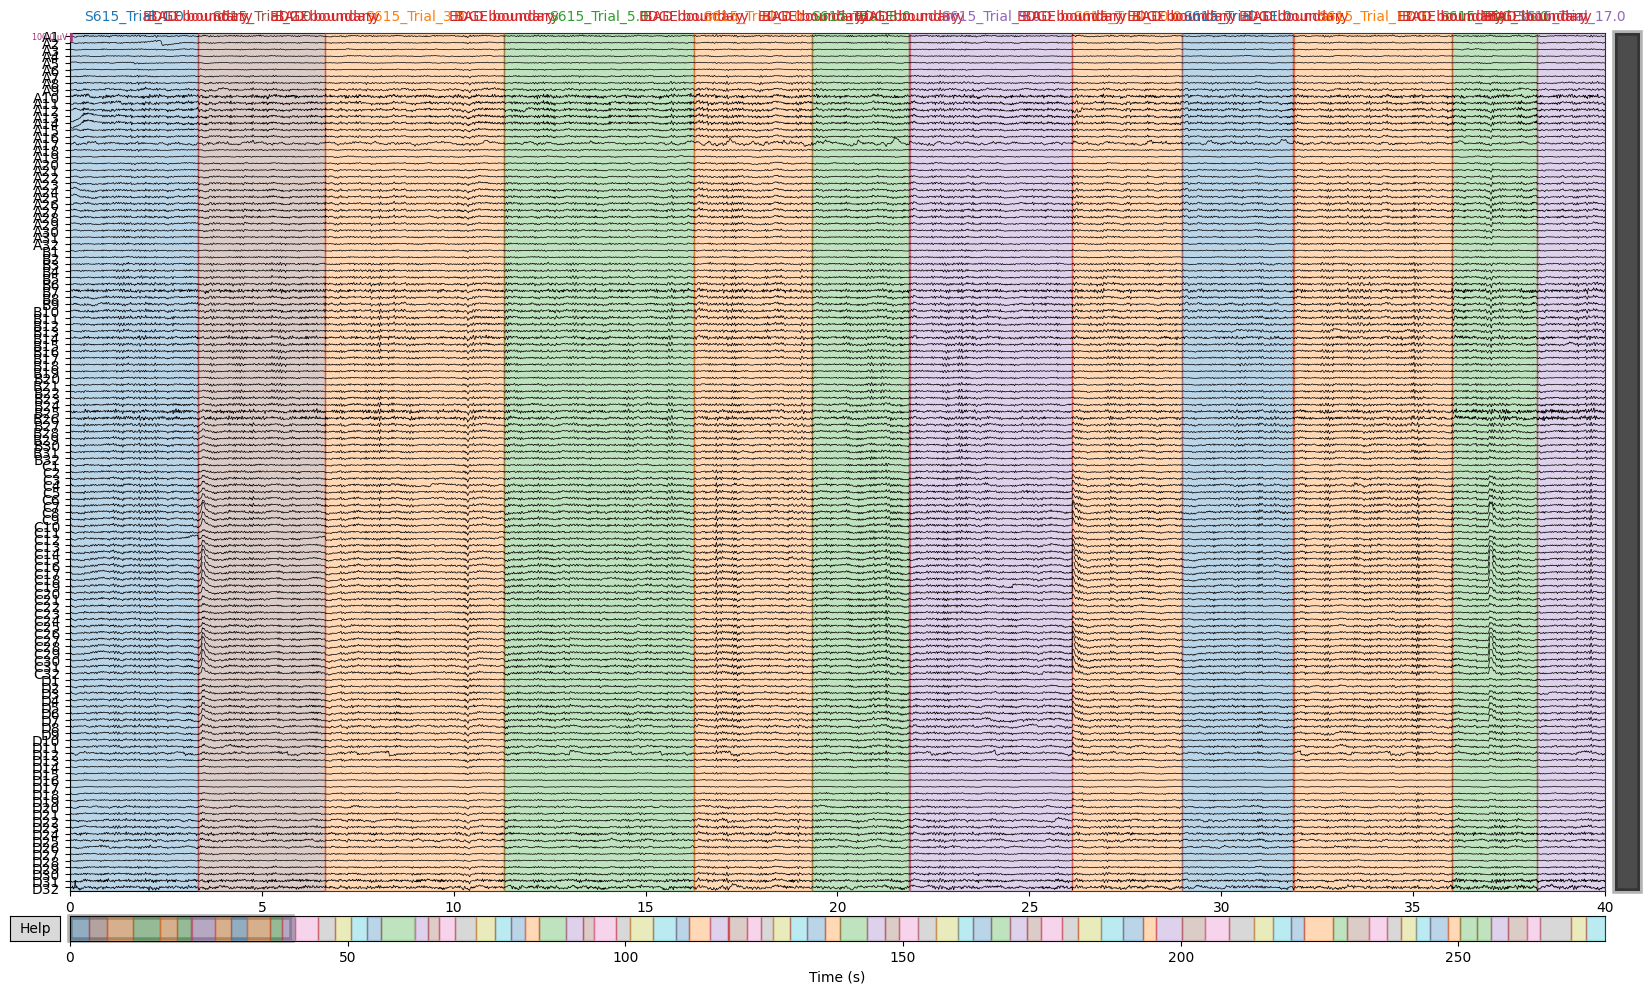

In [7]:
%matplotlib qt 
Stim_RT_data.plot( n_channels=128, scalings=dict(eeg=50e-6), picks = 'eeg', duration = 40)


In [8]:
# load the selected bad channels
with open(os.path.join(workspace_root, 'Data', 'bad_channels_detected.pkl'), "rb") as f:
    detected_noise = pickle.load(f)
detected_noise[subject] = {'channel_names': ['A17','D12','D22','D32'],
                           'trial_numbers': []}
# save the selected bad channels
with open(os.path.join(workspace_root, 'Data', 'bad_channels_detected.pkl'), "wb") as f:
    pickle.dump(detected_noise, f)